In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import chainer
from chainer import links as L
from chainer import functions as F
from chainer import optimizers

from generate_input import load_images_from_folder

from chainer import reporter

from chainer import backend
from chainer import backends
from chainer.backends import cuda
from chainer import Function, gradient_check, report, training, utils, Variable
from chainer import  initializers, iterators, optimizers, serializers
from chainer.training import extensions

import numpy as np

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [46]:
class MRICNN(chainer.Chain):
    def __init__(self, x_shape):
        super(MRICNN, self).__init__()
        size=(64, 1, 5, 5)
        n = size[0] * size[2] * size[3] + size[1] * size[2] * size[3]
        a = np.sqrt(6/n)
        W1 = self.xp.random.uniform(high=a, low=a, size=size)

        size=(64, 64, 5, 5)
        n = size[0] * size[2] * size[3] + size[1] * size[2] * size[3]
        a = np.sqrt(6/n)
        W2 = self.xp.random.uniform(high=a, low=a, size=size)
        
        size=(64, 1, 7, 7)
        n = size[0] * size[2] * size[3] + size[1] * size[2] * size[3]
        a = np.sqrt(6/n)
        W3 = self.xp.random.uniform(high=a, low=a, size=size)
        
        
        with self.init_scope():
            n_out = int(x_shape[0]*x_shape[1])
            self.fc1 = L.Linear(None, n_out)
            self.bn1 = L.BatchNormalization(None, axis=(0))
            self.fc2 = L.Linear(None, n_out)
            self.bn2 = L.BatchNormalization(None, axis=(0))
#             self.conv1 = L.Convolution2D(in_channels=1, out_channels=64, ksize=3, pad=2)
#             self.conv2 = L.Convolution2D(in_channels=64,out_channels=64, ksize=3, pad=2)
#             self.deconv = L.Deconvolution2D(in_channels=64, out_channels=1, ksize=5)

            self.conv1  = L.Convolution2D(in_channels=1, out_channels=64, ksize=5, pad=4)
            self.bn3 = L.BatchNormalization(None, axis=(0))
            self.conv2  = L.Convolution2D(in_channels=64,out_channels=64, ksize=5, pad=4)
            self.bn4 = L.BatchNormalization(None, axis=(0))
            self.deconv = L.Deconvolution2D(in_channels=64, out_channels=1, ksize=7)

#             self.conv1 = L.Convolution2D(in_channels=1, out_channels=64, ksize=5, initialW=W1, pad=4)
#             self.conv2 = L.Convolution2D(in_channels=64, out_channels=64, ksize=5, initialW=W2, pad=4)
#             self.deconv = L.Deconvolution2D(in_channels=64, out_channels=1, ksize=7, initialW=W3)
        
    def __call__(self, x):
        h = x.reshape(x.shape[0], -1)
        
        h = self.fc1(h)
        h = F.tanh(h)
        h = self.bn1(h)
        
        h = self.fc2(h)
        h = F.tanh(h)
        h = self.bn2(h)
        h = h.reshape(x.shape[0], 1, x.shape[1], x.shape[2])
#         print(h.shape)
        h = self.conv1(h)
        h = F.relu(h)
        h = self.bn3(h)
#         print(h.shape)
        h = self.conv2(h)
        h = F.relu(h)
        h = self.bn4(h)
#         print(h.shape)
        h = self.deconv(h)
        h = h[:, :, 7:-7, 7:-7]
#         print(h.shape)
        
        return h


In [35]:
def compute_cost(x, y):
    x = x[:, 0, :, :]
    cost = F.mean_squared_error(x, y)
    return cost

In [36]:
class Minimizer(chainer.Chain):
    def __init__(self, model, loss_fun):
        super(Minimizer, self).__init__()
        with self.init_scope():
            self.model = model
            
        self.loss_fun = loss_fun
        self.noise = True
        self.report = True
        
    def forward(self, *args):
        if self.noise:
            noise = self.xp.random.normal(size=args[0].shape)
            noise = noise.astype(np.float32)
        else:
            noise = 0
        self.y = self.model(args[0] + noise)
        self.loss = self.loss_fun(self.y, args[1])
        if self.report:
            reporter.report({'loss':self.loss}, self)
        return self.loss

In [37]:
dir_train = '/home/genta/dataset/tiny-imagenet-200/test/images/'  # Folder with images
n_im = 10000  # How many images to load
X_train, Y_train = load_images_from_folder(  # Load images for training
    dir_train,
    n_im,
    normalize=False,
    imrotate=True,
    search_dirs = None,
    transform='radon'
)
print('X_train.shape at input = ', X_train.shape)
print('Y_train.shape at input = ', Y_train.shape)

/home/genta/.pyenv/versions/anaconda-4.0.0/envs/chainer/lib/python3.6/site-packages/skimage/transform/radon_transform.py:69: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


X_train.shape at input =  (40000, 64, 64, 1)
Y_train.shape at input =  (40000, 64, 64)


In [38]:
print(X_train.max(), X_train.min(), X_train.mean())
print(Y_train.max(), Y_train.min(), Y_train.mean())

16320.0 0.0 6392.35180186
255.0 0.0 113.429427441


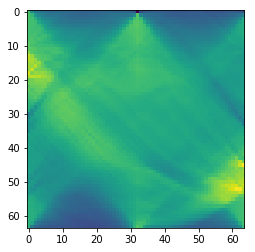

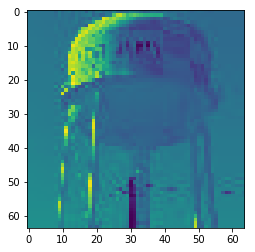

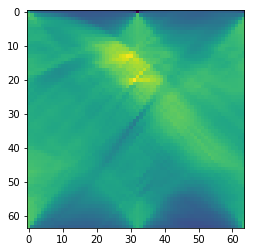

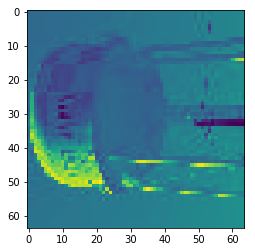

In [39]:
plt.imshow(X_train[0][:, :, 0])
plt.show()

plt.imshow(Y_train[0])
plt.show()

plt.imshow(X_train[1][:, :, 0])
plt.show()

plt.imshow(Y_train[1])
plt.show()

In [40]:
X_train = X_train.astype(np.float32)
X_train = X_train - X_train.min()
X_train /= X_train.max()
Y_train = Y_train.astype(np.float32)
Y_train = Y_train - Y_train.min()
Y_train /= Y_train.max()

In [41]:
print(X_train.max(), X_train.min(), X_train.mean())
print(Y_train.max(), Y_train.min(), Y_train.mean())

1.0 0.0 0.391688
1.0 0.0 0.444823


In [42]:
n_test = X_train.shape[0]//4
train = [(i, j) for i, j in zip(X_train[n_test:, :], Y_train[n_test:, :])]
test = [(i, j) for i, j in zip(X_train[:n_test, :], Y_train[:n_test, :])]

In [43]:
len(train), len(test)

(30000, 10000)

In [47]:
def main():
    max_epoch = 10
    gpu_id = 0
    lr = 0.0002
    batchsize = 100

    train_iter = iterators.SerialIterator(train, batchsize)
    test_iter = iterators.SerialIterator(test, batchsize, False, False)

    preditor = MRICNN(X_train[0].shape)
    preditor.to_gpu()
    model = Minimizer(preditor, compute_cost)
    optimizer = optimizers.RMSprop(lr=lr, alpha=0.9)
#     optimizer = optimizers.MomentumSGD(lr=lr, momentum=0.9)
#     optimizer = optimizers.Adam(alpha=lr)
#     optimizer = optimizers.NesterovAG(lr=lr)
    optimizer.setup(model)
    optimizer.add_hook(chainer.optimizer_hooks.Lasso(0.0001))

    updater = training.updaters.StandardUpdater(train_iter, optimizer, device=gpu_id)
    trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='result')
    trainer.extend(extensions.LogReport())
    trainer.extend(extensions.snapshot_object(model.model, filename='model_epoch-{.updater.epoch}'),
                   trigger=training.triggers.IntervalTrigger(5, unit='epoch'))
    trainer.extend(extensions.Evaluator(test_iter, model, device=gpu_id))
    trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss', 'elapsed_time']))
    trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', file_name='loss.png'))
    trainer.extend(extensions.dump_graph('main/loss'))
    return trainer, optimizer

In [48]:
trainer, optimizer = main()

In [49]:
trainer.run()

epoch       main/loss   validation/main/loss  elapsed_time
1           7.91544     2.5416                36.8518       
2           1.37915     0.326929              71.7885       
3           0.401517    0.17091               107.028       
4           0.28681     0.240837              142.465       
5           0.21861     1.52578               177.916       
6           0.178205    0.973179              219.785       
7           0.150437    0.0955723             255.224       
8           0.127468    0.440143              290.726       
9           0.11009     0.180546              326.302       
10          0.0976138   0.118508              361.869       


In [50]:
train[0][1]

array([[ 0.87058824,  0.90588236,  0.92156863, ...,  0.84705883,
         0.86666667,  0.9254902 ],
       [ 0.81568629,  0.8509804 ,  0.87058824, ...,  0.8509804 ,
         0.85882354,  0.83529413],
       [ 0.80784315,  0.85490197,  0.81568629, ...,  0.89019608,
         0.88627452,  0.84705883],
       ..., 
       [ 0.90588236,  0.96862745,  0.89803922, ...,  0.81568629,
         0.83529413,  0.89411765],
       [ 0.96470588,  0.88235295,  0.82352942, ...,  0.89803922,
         0.87450981,  0.84705883],
       [ 0.92156863,  0.89019608,  0.95294118, ...,  0.90196079,
         0.88627452,  0.86274511]], dtype=float32)

In [51]:
model = optimizer.target

model.to_cpu()

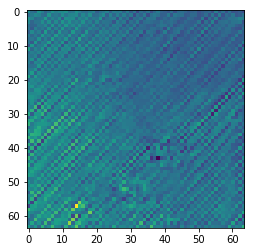

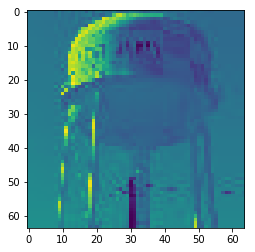

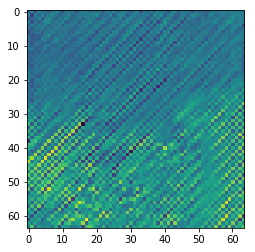

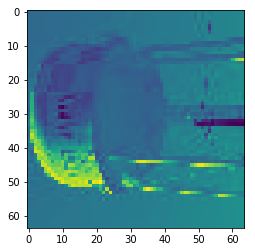

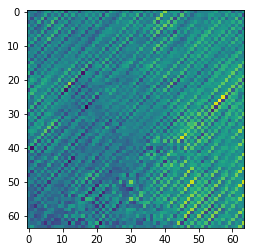

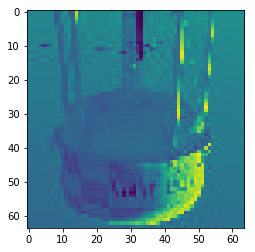

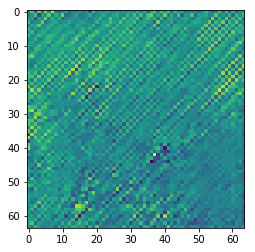

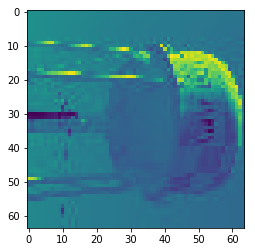

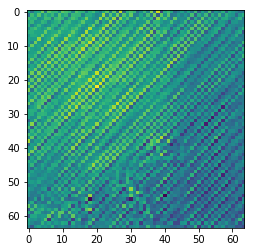

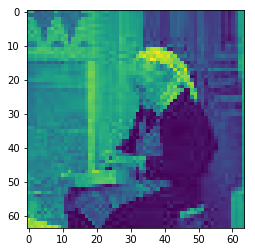

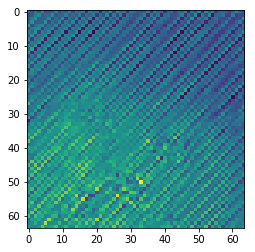

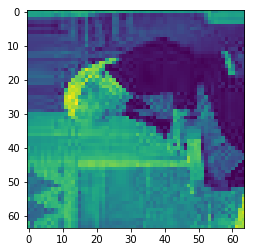

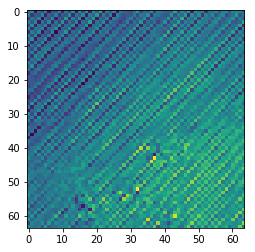

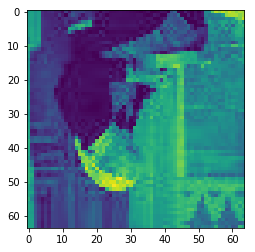

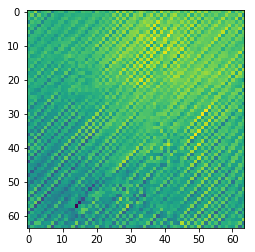

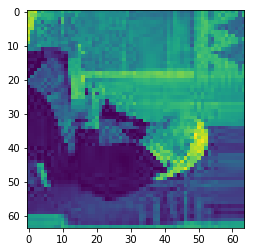

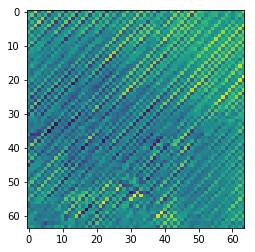

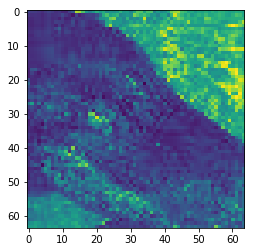

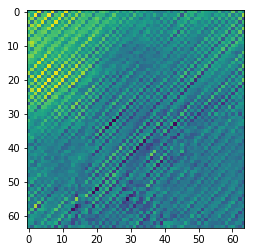

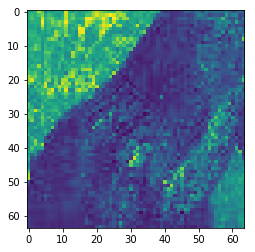

In [52]:
out = model.model(X_train[:10])

for i in range(10):
    plt.imshow(out.data[i, 0])
    plt.show()
    plt.imshow(Y_train[i])
    plt.show()

In [53]:
import optuna

In [54]:
print(n_test)

10000


In [69]:
def objective(trial):
    gpu_id = 0
    batchsize = 100
#     max_epoch = trial.suggest_discrete_uniform('max_epoch', 1, 5, 1)
    max_epoch = 20
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
    alpha = trial.suggest_uniform('alpha', 0.85, 1)
    lasso_alpha = trial.suggest_loguniform('lass_alpha', 1e-5, 1e-3)
    print('trial ', trial.number)
    print('max_epoch\t', max_epoch)
    print('lr\t', lr)
    print('alpha\t', alpha)
    print('lasso_alpha\t', lasso_alpha)

    train_iter = iterators.SerialIterator(train, batchsize)
    test_iter = iterators.SerialIterator(test, batchsize, False, False)

    preditor = MRICNN(X_train[0].shape)
    preditor.to_gpu(0)
    model = Minimizer(preditor, compute_cost)
    optimizer = optimizers.RMSprop(lr=lr, alpha=alpha)
    optimizer.setup(model)
#     optimizer.add_hook(chainer.optimizer_hooks.Lasso(lasso_alpha))

    updater = training.updaters.StandardUpdater(train_iter, optimizer, device=gpu_id)
    trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='result')
    trainer.extend(extensions.Evaluator(test_iter, model, device=gpu_id))
    trainer.extend(extensions.snapshot_object(model.model, filename='model_num{}'.format(trial.number)),
               trigger=training.triggers.IntervalTrigger(max_epoch, unit='epoch'))

    trainer.extend(extensions.LogReport())
    trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'validation/main/loss', 'elapsed_time']))
    trainer.run()
    
    loss = []
    model.noise = False
    model.report = False
    for i in range(0, n_test, 100):
        x = X_train[i:i+100]
        y = Y_train[i:i+100]
        t = model(cuda.to_gpu(x), cuda.to_gpu(y))
        loss.append(cuda.to_cpu(t.data))
    loss = np.asarray(loss)
    loss = loss.sum() / n_test
    print(loss)
    return loss

In [70]:
%%time

study = optuna.create_study()
study.optimize(objective, n_trials=20)

trial  0
max_epoch	 20
lr	 0.000133604151547
alpha	 0.9811471992906318
lasso_alpha	 1.74712290871e-05
epoch       main/loss   validation/main/loss  elapsed_time
1           8.19359     3.20446               33.6905       
2           1.2587      0.493823              67.8708       
3           0.379077    0.246863              102.397       
4           0.269241    0.591449              137.074       
5           0.222166    0.154919              171.816       
6           0.197188    0.175057              206.668       
7           0.177455    0.166662              241.552       
8           0.163903    0.104655              276.472       
9           0.152963    0.111974              311.417       
10          0.144677    0.142412              346.358       
11          0.136517    0.159235              381.347       
12          0.131408    0.0746627             416.371       
13          0.125134    0.0880258             451.504       
14          0.121523    0.0942762             

[I 2019-04-07 18:11:18,052] Finished trial#0 resulted in value: 0.0006944519996643066. Current best value is 0.0006944519996643066 with parameters: {'lr': 0.00013360415154748688, 'alpha': 0.9811471992906318, 'lass_alpha': 1.7471229087137582e-05}.


trial  1
max_epoch	 20
lr	 4.76904937335e-05
alpha	 0.8653684629862041
lasso_alpha	 0.000674545804827
epoch       main/loss   validation/main/loss  elapsed_time
1           12.2458     4.30892               35.0286       
2           3.41012     2.21446               70.3082       
3           2.05629     1.32518               105.813       
4           0.813698    0.302312              141.223       
5           0.226265    0.150553              176.773       
6           0.141648    0.135769              212.186       
7           0.115203    0.0980481             247.606       
8           0.102071    0.0931705             283.129       
9           0.0942009   0.0806211             318.543       
10          0.088614    0.0792378             354.137       
11          0.0842488   0.0777403             389.551       
12          0.0809086   0.0801271             424.959       
13          0.0780428   0.0753932             460.189       
14          0.0756942   0.0763854             

[I 2019-04-07 18:23:13,111] Finished trial#1 resulted in value: 0.0005967733860015869. Current best value is 0.0005967733860015869 with parameters: {'lr': 4.769049373353262e-05, 'alpha': 0.8653684629862041, 'lass_alpha': 0.00067454580482703252}.


trial  2
max_epoch	 20
lr	 0.000520830517448
alpha	 0.9580349289472873
lasso_alpha	 3.8157750183e-05
epoch       main/loss   validation/main/loss  elapsed_time
1           7.24896     2.27328               34.9085       
2           1.04539     0.670552              69.8682       
3           0.533042    0.436794              104.816       
4           0.407432    0.290593              139.776       
5           0.339726    0.417483              174.734       
6           0.296187    0.259673              209.69        
7           0.26327     0.238317              244.65        
8           0.23481     0.27602               279.595       
9           0.212023    0.224419              314.569       
10          0.195969    0.139726              349.563       
11          0.184526    0.256286              384.605       
12          0.176771    0.108818              419.695       
13          0.167068    0.195639              454.849       
14          0.161294    0.185834              4

[I 2019-04-07 18:35:04,807] Finished trial#2 resulted in value: 0.001348548412322998. Current best value is 0.0005967733860015869 with parameters: {'lr': 4.769049373353262e-05, 'alpha': 0.8653684629862041, 'lass_alpha': 0.00067454580482703252}.


trial  3
max_epoch	 20
lr	 0.000786109146256
alpha	 0.8704141480306238
lasso_alpha	 1.34637907919e-05
epoch       main/loss   validation/main/loss  elapsed_time
1           7.36487     2.76791               35.0357       
2           1.27264     0.614055              70.3608       
3           0.563849    0.433496              105.881       
4           0.370415    0.201317              141.422       
5           0.294505    0.19865               176.898       
6           0.251203    0.250008              212.521       
7           0.220774    0.236379              248.017       
8           0.20231     0.199889              283.699       
9           0.184478    0.18606               319.283       
10          0.170606    0.197625              354.878       
11          0.159711    0.148008              390.575       
12          0.149891    0.188032              426.152       
13          0.14067     0.14358               461.665       
14          0.132969    0.162714              

[I 2019-04-07 18:47:03,301] Finished trial#3 resulted in value: 0.0009674110412597656. Current best value is 0.0005967733860015869 with parameters: {'lr': 4.769049373353262e-05, 'alpha': 0.8653684629862041, 'lass_alpha': 0.00067454580482703252}.


trial  4
max_epoch	 20
lr	 2.73316184384e-05
alpha	 0.9988250403014816
lasso_alpha	 8.13599360933e-05
epoch       main/loss   validation/main/loss  elapsed_time
1           10.2182     5.33768               34.9816       
2           4.59234     3.24819               69.9927       
3           2.82107     1.87392               105.01        
4           1.38655     0.817211              140.049       
5           0.65536     0.464825              175.077       
6           0.414654    0.321753              210.124       
7           0.307049    0.253488              245.136       
8           0.246111    0.211793              280.159       
9           0.206386    0.183004              315.165       
10          0.179388    0.152831              350.199       
11          0.158612    0.140949              385.224       
12          0.142304    0.126046              420.269       
13          0.13164     0.121635              455.327       
14          0.11982     0.107292              

[I 2019-04-07 18:58:54,939] Finished trial#4 resulted in value: 0.0007841079711914063. Current best value is 0.0005967733860015869 with parameters: {'lr': 4.769049373353262e-05, 'alpha': 0.8653684629862041, 'lass_alpha': 0.00067454580482703252}.


trial  5
max_epoch	 20
lr	 7.02448298732e-05
alpha	 0.8802885126836829
lasso_alpha	 0.000334327823258
epoch       main/loss   validation/main/loss  elapsed_time
1           10.3273     3.68147               35.0438       
2           2.20634     0.906486              70.1417       
3           0.462609    0.300164              105.264       
4           0.208539    0.20225               140.389       
5           0.138911    0.124132              175.555       
6           0.111404    0.101328              210.702       
7           0.0972611   0.101112              245.806       
8           0.0884068   0.0961269             280.881       
9           0.0823492   0.078398              315.965       
10          0.0778638   0.0766053             351.055       
11          0.0744516   0.0825072             386.122       
12          0.0717172   0.0777741             421.213       
13          0.0696125   0.0680494             456.307       
14          0.0676945   0.06904               

[I 2019-04-07 19:10:47,012] Finished trial#5 resulted in value: 0.00062815842628479. Current best value is 0.0005967733860015869 with parameters: {'lr': 4.769049373353262e-05, 'alpha': 0.8653684629862041, 'lass_alpha': 0.00067454580482703252}.


trial  6
max_epoch	 20
lr	 4.14128767674e-05
alpha	 0.8637399848797931
lasso_alpha	 0.000269525895036
epoch       main/loss   validation/main/loss  elapsed_time
1           14.0773     5.0078                34.9495       
2           3.77292     2.27355               69.9307       
3           1.43479     0.486166              104.913       
4           0.295672    0.176059              139.897       
5           0.16609     0.130781              174.883       
6           0.129392    0.110503              209.848       
7           0.111518    0.0909044             244.798       
8           0.100448    0.0865197             279.752       
9           0.0929655   0.0803402             314.685       
10          0.0871649   0.0821672             349.619       
11          0.0826916   0.0693244             384.552       
12          0.0791248   0.0819243             419.487       
13          0.0764092   0.0706046             454.447       
14          0.0738939   0.0629146             

[I 2019-04-07 19:22:36,917] Finished trial#6 resulted in value: 0.0006455708503723145. Current best value is 0.0005967733860015869 with parameters: {'lr': 4.769049373353262e-05, 'alpha': 0.8653684629862041, 'lass_alpha': 0.00067454580482703252}.


trial  7
max_epoch	 20
lr	 3.11927624139e-05
alpha	 0.9397867819276746
lasso_alpha	 1.39803874658e-05
epoch       main/loss   validation/main/loss  elapsed_time
1           15.5673     6.07958               35.0424       
2           4.44263     2.72406               70.1151       
3           2.30382     1.41497               105.236       
4           0.950404    0.408883              140.399       
5           0.250879    0.167921              175.548       
6           0.13776     0.106524              210.694       
7           0.107366    0.103557              245.821       
8           0.0932795   0.0864815             280.926       
9           0.084831    0.0727871             316.039       
10          0.0792886   0.07129               351.149       
11          0.0751934   0.0632478             386.242       
12          0.0720362   0.0631795             421.365       
13          0.0694999   0.0633923             456.448       
14          0.0675843   0.0644782             

[I 2019-04-07 19:34:29,186] Finished trial#7 resulted in value: 0.000529179859161377. Current best value is 0.000529179859161377 with parameters: {'lr': 3.1192762413924849e-05, 'alpha': 0.9397867819276746, 'lass_alpha': 1.3980387465768658e-05}.


trial  8
max_epoch	 20
lr	 1.62020254807e-05
alpha	 0.8744722756424551
lasso_alpha	 0.000115552128121
epoch       main/loss   validation/main/loss  elapsed_time
1           21.2791     10.4573               35.0044       
2           7.75615     5.07126               70.0405       
3           4.43165     3.10204               105.127       
4           2.93337     2.07025               140.222       
5           1.99335     1.38618               175.291       
6           1.22168     0.754283              210.363       
7           0.525383    0.256737              245.415       
8           0.177832    0.116329              280.435       
9           0.10064     0.0818837             315.446       
10          0.0766982   0.0680706             350.453       
11          0.0658393   0.0598184             385.419       
12          0.059729    0.0553639             420.405       
13          0.055692    0.0522273             455.368       
14          0.0529538   0.0499314             

[I 2019-04-07 19:46:19,873] Finished trial#8 resulted in value: 0.0004353520393371582. Current best value is 0.0004353520393371582 with parameters: {'lr': 1.6202025480658848e-05, 'alpha': 0.8744722756424551, 'lass_alpha': 0.00011555212812087648}.


trial  9
max_epoch	 20
lr	 4.45204050591e-05
alpha	 0.99341984256197
lasso_alpha	 0.000128156726491
epoch       main/loss   validation/main/loss  elapsed_time
1           10.5045     5.20518               34.9655       
2           4.25084     2.77801               69.9961       
3           2.2867      1.17182               105.102       
4           0.727458    0.319003              140.101       
5           0.193014    0.114873              174.992       
6           0.103325    0.0922579             209.814       
7           0.0816233   0.0680801             244.595       
8           0.0730587   0.0627796             279.325       
9           0.0695759   0.102542              314.012       
10          0.0622493   0.0664351             348.712       
11          0.0579408   0.0502555             383.41        
12          0.0536133   0.0466653             418.108       
13          0.052625    0.0460881             452.824       
14          0.050602    0.0498799             48

[I 2019-04-07 19:58:05,804] Finished trial#9 resulted in value: 0.0005270683765411377. Current best value is 0.0004353520393371582 with parameters: {'lr': 1.6202025480658848e-05, 'alpha': 0.8744722756424551, 'lass_alpha': 0.00011555212812087648}.


trial  10
max_epoch	 20
lr	 1.24560126265e-05
alpha	 0.908520667235
lasso_alpha	 0.00099364237996
epoch       main/loss   validation/main/loss  elapsed_time
1           23.707      12.8395               34.9799       
2           9.83746     6.8181                70.024        
3           5.95599     4.37856               105.178       
4           4.18275     3.14909               140.344       
5           3.17922     2.39857               175.503       
6           2.48437     1.86108               210.644       
7           1.90221     1.39048               245.748       
8           1.34629     0.941846              280.85        
9           0.805224    0.499388              315.893       
10          0.378226    0.238911              350.985       
11          0.201436    0.151986              386.05        
12          0.141292    0.116518              421.129       
13          0.113156    0.0973637             456.186       
14          0.096438    0.0857347             491.

[I 2019-04-07 20:09:57,611] Finished trial#10 resulted in value: 0.0005986515045166015. Current best value is 0.0004353520393371582 with parameters: {'lr': 1.6202025480658848e-05, 'alpha': 0.8744722756424551, 'lass_alpha': 0.00011555212812087648}.


trial  11
max_epoch	 20
lr	 0.000162850193645
alpha	 0.902632420937
lasso_alpha	 3.92650401017e-05
epoch       main/loss   validation/main/loss  elapsed_time
1           8.03613     2.89271               34.9414       
2           1.78632     0.423068              70.009        
3           0.420169    0.332341              105.101       
4           0.281232    0.222448              140.225       
5           0.232266    0.317989              175.369       
6           0.204008    0.1565                210.509       
7           0.184915    0.189224              245.654       
8           0.168648    0.149147              280.8         
9           0.1597      0.257765              315.949       
10          0.149372    0.148101              351.065       
11          0.143187    0.209372              386.174       
12          0.1359      0.105993              421.292       
13          0.131508    0.101984              456.4         
14          0.126174    0.204472              491

[I 2019-04-07 20:21:49,998] Finished trial#11 resulted in value: 0.0010086801528930663. Current best value is 0.0004353520393371582 with parameters: {'lr': 1.6202025480658848e-05, 'alpha': 0.8744722756424551, 'lass_alpha': 0.00011555212812087648}.


trial  12
max_epoch	 20
lr	 1.13042295339e-05
alpha	 0.893529984851
lasso_alpha	 0.000142240085172
epoch       main/loss   validation/main/loss  elapsed_time
1           25.0375     13.6992               35.0801       
2           10.5064     7.35244               70.232        
3           6.39441     4.73446               105.397       
4           4.47654     3.38721               140.581       
5           3.39259     2.58477               175.705       
6           2.67256     2.03014               210.825       
7           2.1149      1.58977               245.929       
8           1.62889     1.20607               281.04        
9           1.1766      0.838595              316.156       
10          0.721197    0.451904              351.268       
11          0.340525    0.214798              386.334       
12          0.182601    0.139007              421.407       
13          0.128707    0.106147              456.455       
14          0.104331    0.0910579             491

[I 2019-04-07 20:33:41,832] Finished trial#12 resulted in value: 0.0006239295482635499. Current best value is 0.0004353520393371582 with parameters: {'lr': 1.6202025480658848e-05, 'alpha': 0.8744722756424551, 'lass_alpha': 0.00011555212812087648}.


trial  13
max_epoch	 20
lr	 1.01315760854e-05
alpha	 0.853270191598
lasso_alpha	 0.000415437466938
epoch       main/loss   validation/main/loss  elapsed_time
1           29.3142     16.1954               34.9285       
2           12.4777     8.84558               69.9065       
3           7.68862     5.76098               105.011       
4           5.39045     4.09586               140.143       
5           4.02706     3.04775               175.282       
6           3.06646     2.29918               210.426       
7           2.27056     1.65335               245.603       
8           1.52078     1.0336                280.777       
9           0.802878    0.471017              315.953       
10          0.346045    0.225529              351.136       
11          0.195194    0.15006               386.307       
12          0.140425    0.115349              421.461       
13          0.113766    0.0992752             456.603       
14          0.098797    0.0871408             491

[I 2019-04-07 20:45:34,744] Finished trial#13 resulted in value: 0.0006681668758392334. Current best value is 0.0004353520393371582 with parameters: {'lr': 1.6202025480658848e-05, 'alpha': 0.8744722756424551, 'lass_alpha': 0.00011555212812087648}.


trial  14
max_epoch	 20
lr	 0.000302844655805
alpha	 0.932980478627
lasso_alpha	 4.84677883009e-05
epoch       main/loss   validation/main/loss  elapsed_time
1           7.6719      2.50456               35.0138       
2           2.1018      1.23552               70.1744       
3           0.898309    0.491713              105.345       
4           0.494656    0.374005              140.512       
5           0.365907    0.362018              175.612       
6           0.295714    0.241497              210.673       
7           0.254695    0.185287              245.721       
8           0.226999    0.208119              280.788       
9           0.206705    0.271962              315.843       
10          0.189786    0.152172              350.893       
11          0.17571     0.155278              385.91        
12          0.16497     0.168257              420.935       
13          0.154025    0.130962              455.924       
14          0.145975    0.149496              490

[I 2019-04-07 20:57:25,117] Finished trial#14 resulted in value: 0.000968123435974121. Current best value is 0.0004353520393371582 with parameters: {'lr': 1.6202025480658848e-05, 'alpha': 0.8744722756424551, 'lass_alpha': 0.00011555212812087648}.


trial  15
max_epoch	 20
lr	 2.02884068669e-05
alpha	 0.911921178911
lasso_alpha	 0.000179793233132
epoch       main/loss   validation/main/loss  elapsed_time
1           18.6898     8.51478               34.9002       
2           6.26555     4.02268               69.8283       
3           3.59171     2.50349               104.895       
4           2.43343     1.71212               139.98        
5           1.6084      1.02521               175.078       
6           0.673355    0.303351              210.194       
7           0.223444    0.153916              245.323       
8           0.137745    0.110013              280.441       
9           0.106424    0.091052              315.574       
10          0.0917523   0.0785798             350.728       
11          0.0829673   0.0741634             385.866       
12          0.0771663   0.070706              421.012       
13          0.0727311   0.0694292             456.12        
14          0.0690423   0.0677295             491

[I 2019-04-07 21:09:17,303] Finished trial#15 resulted in value: 0.000562900972366333. Current best value is 0.0004353520393371582 with parameters: {'lr': 1.6202025480658848e-05, 'alpha': 0.8744722756424551, 'lass_alpha': 0.00011555212812087648}.


trial  16
max_epoch	 20
lr	 1.86269535307e-05
alpha	 0.890442292288
lasso_alpha	 2.57170865295e-05
epoch       main/loss   validation/main/loss  elapsed_time
1           21.0902     9.85585               35.0487       
2           7.28648     4.76767               70.1846       
3           4.22677     3.00037               105.349       
4           2.93294     2.1364                140.533       
5           2.19098     1.60795               175.93        
6           1.65763     1.20457               211.1         
7           1.12997     0.710176              246.401       
8           0.46216     0.226201              281.566       
9           0.174917    0.125284              316.653       
10          0.115262    0.0941978             351.764       
11          0.0930711   0.079198              386.857       
12          0.0817423   0.0728727             421.933       
13          0.0749563   0.0695043             456.984       
14          0.0703976   0.0640549             492

[I 2019-04-07 21:21:09,622] Finished trial#16 resulted in value: 0.0005767786026000977. Current best value is 0.0004353520393371582 with parameters: {'lr': 1.6202025480658848e-05, 'alpha': 0.8744722756424551, 'lass_alpha': 0.00011555212812087648}.


trial  17
max_epoch	 20
lr	 8.58192925162e-05
alpha	 0.98082450451
lasso_alpha	 8.91868673047e-05
epoch       main/loss   validation/main/loss  elapsed_time
1           8.59119     3.46108               34.8843       
2           2.67435     1.51293               69.8083       
3           0.775236    0.286822              104.76        
4           0.225919    0.180787              139.744       
5           0.155989    0.22627               174.786       
6           0.129476    0.11202               209.845       
7           0.11743     0.0968475             244.957       
8           0.105951    0.086122              280.154       
9           0.101789    0.0653508             315.435       
10          0.0964862   0.0856502             350.689       
11          0.0927892   0.220619              385.981       
12          0.0908216   0.0786386             421.386       
13          0.0866983   0.147491              456.788       
14          0.0863921   0.0853779             492.

[I 2019-04-07 21:33:04,724] Finished trial#17 resulted in value: 0.0008053501129150391. Current best value is 0.0004353520393371582 with parameters: {'lr': 1.6202025480658848e-05, 'alpha': 0.8744722756424551, 'lass_alpha': 0.00011555212812087648}.


trial  18
max_epoch	 20
lr	 6.03909315466e-05
alpha	 0.980786811484
lasso_alpha	 0.000158107919942
epoch       main/loss   validation/main/loss  elapsed_time
1           10.4955     4.3261                35.0391       
2           2.79094     0.766163              70.478        
3           0.3054      0.123841              105.743       
4           0.103211    0.0740612             141.024       
5           0.0831446   0.0763397             176.236       
6           0.0763479   0.0624793             211.414       
7           0.0724598   0.0780094             246.569       
8           0.0677513   0.0634366             281.518       
9           0.0624979   0.0594689             316.285       
10          0.0594711   0.0501219             351.051       
11          0.057764    0.045655              385.733       
12          0.0554206   0.0434985             420.337       
13          0.0549021   0.0670555             454.902       
14          0.0538586   0.0448874             489

[I 2019-04-07 21:44:51,522] Finished trial#18 resulted in value: 0.0004118581295013428. Current best value is 0.0004118581295013428 with parameters: {'lr': 6.0390931546552471e-05, 'alpha': 0.98078681148429436, 'lass_alpha': 0.0001581079199420478}.


trial  19
max_epoch	 20
lr	 0.000216594976868
alpha	 0.956943061526
lasso_alpha	 6.18079571988e-05
epoch       main/loss   validation/main/loss  elapsed_time
1           7.93371     2.88344               34.896        
2           2.3385      1.51826               69.8199       
3           1.08705     0.504833              104.752       
4           0.403865    0.249723              139.697       
5           0.247057    0.324168              174.641       
6           0.190807    0.235078              209.599       
7           0.16564     0.184204              244.589       
8           0.155821    0.182631              279.697       
9           0.146427    0.184825              314.954       
10          0.141438    0.104617              350.098       
11          0.133526    0.0793974             385.286       
12          0.126914    0.119628              420.599       
13          0.120076    0.0909322             455.867       
14          0.115536    0.067772              491

[I 2019-04-07 21:56:45,532] Finished trial#19 resulted in value: 0.0009214534759521485. Current best value is 0.0004118581295013428 with parameters: {'lr': 6.0390931546552471e-05, 'alpha': 0.98078681148429436, 'lass_alpha': 0.0001581079199420478}.


CPU times: user 2h 38min 21s, sys: 1h 18min 44s, total: 3h 57min 6s
Wall time: 3h 57min 16s


In [71]:
study.best_params

{'alpha': 0.98078681148429436,
 'lass_alpha': 0.0001581079199420478,
 'lr': 6.0390931546552471e-05}

In [72]:
min_num = -1
min_value = 1e2
for tr in study.trials:
    if tr.value < min_value:
        min_value = tr.value
        min_num = tr.number

In [73]:
study.trials[min_num].params

{'alpha': 0.98078681148429436,
 'lass_alpha': 0.0001581079199420478,
 'lr': 6.0390931546552471e-05}

In [58]:
predictor = MRICNN(X_train[0].shape)
serializers.load_npz('./result/model', predictor)

In [59]:
i = 100

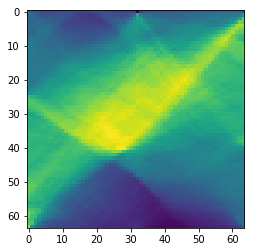

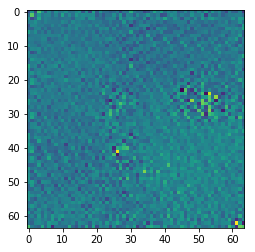

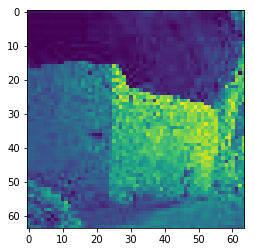

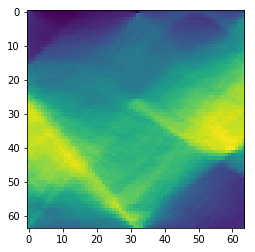

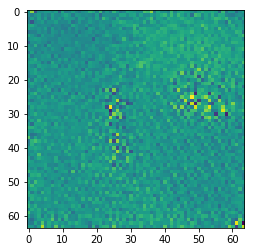

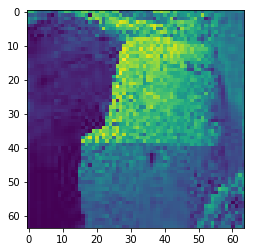

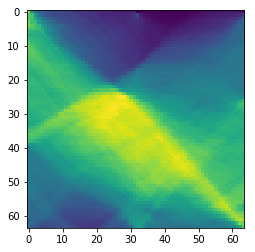

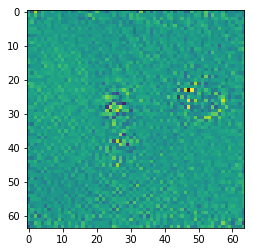

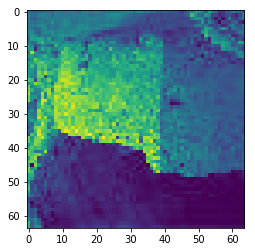

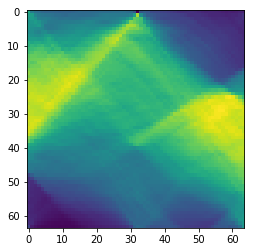

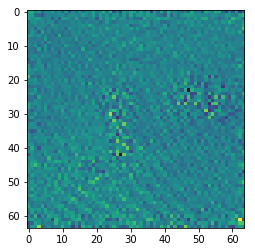

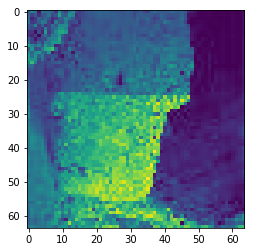

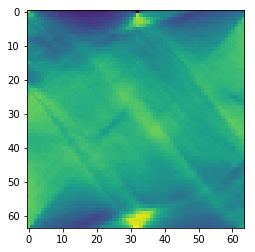

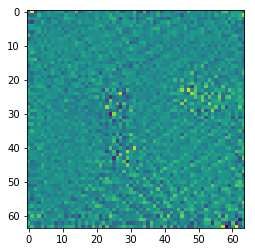

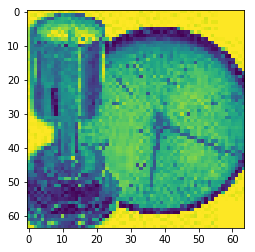

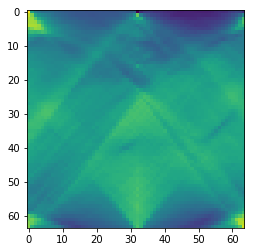

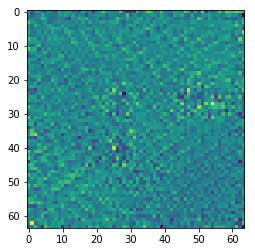

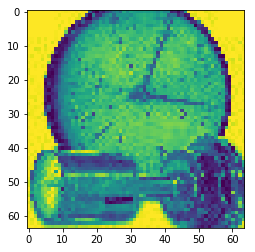

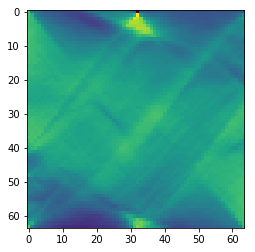

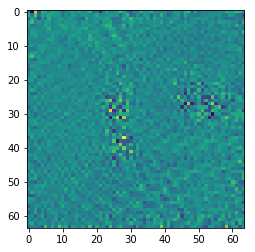

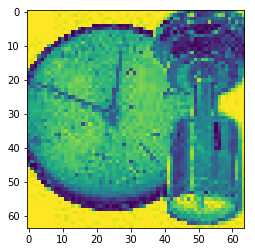

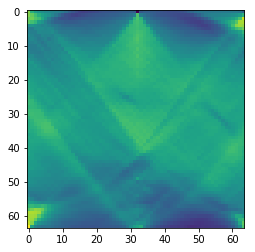

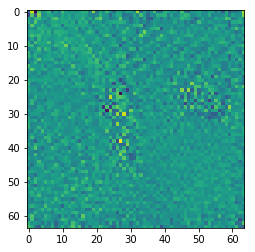

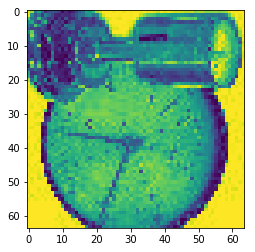

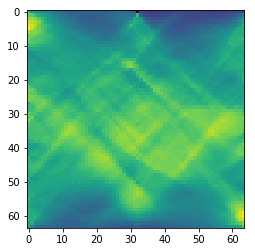

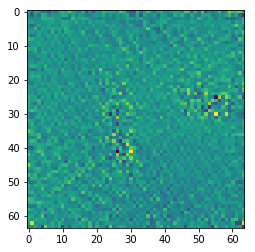

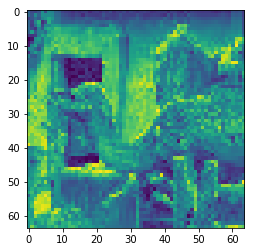

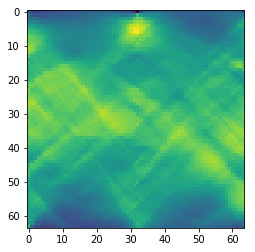

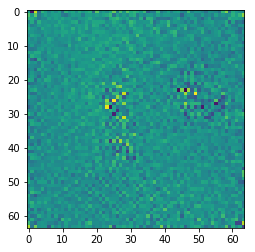

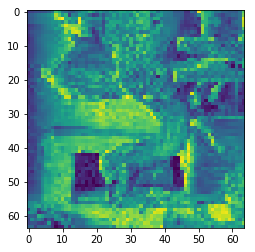

In [61]:
j = 100
out = predictor(X_train[j:j+10])

for i in range(10):
    plt.imshow(X_train[j+i][:, :, 0])
    plt.show()    
    plt.imshow(out.data[i, 0])
    plt.show()
    plt.imshow(Y_train[j+i])
    plt.show()